# Build an object detector from scratch
Based on https://jovian.ml/aakanksha-ns/road-signs-bounding-box-prediction
with modifications

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from pathlib import Path
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

%matplotlib inline
%load_ext lab_black

d:\Python\General\03_Projects\neural_nets\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Dataset: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection
images_path = Path("../data/traffic_signs/images")
anno_path = Path("../data/traffic_signs/annotations")

In [3]:
def filelist(root: str, file_type: str) -> "list[str]":
    """
    Returns a fully-qualified list of filenames under root directory.
    Args:
        root (str): The path of the root directory to search for files.
        file_type (str): The file extension to filter the results by (e.g '.xml').
    Returns:
        list: A list of fully-qualified filenames.
    """
    return [
        os.path.join(directory_path, f)
        for directory_path, directory_name, files in os.walk(root)
        for f in files
        if f.endswith(file_type)
    ]


def generate_train_df(anno_path: str) -> pd.DataFrame:
    """
    Generates a DataFrame of annotations from a given annotation path.
    Args:
        anno_path (str): The path of the annotations.
    Returns:
        pd.DataFrame: A DataFrame containing the annotations.
    """
    annotations = filelist(anno_path, ".xml")
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno["filename"] = Path(str(images_path) + "/" + root.find("./filename").text)
        anno["width"] = root.find("./size/width").text
        anno["height"] = root.find("./size/height").text
        anno["class"] = root.find("./object/name").text
        anno["xmin"] = int(root.find("./object/bndbox/xmin").text)
        anno["ymin"] = int(root.find("./object/bndbox/ymin").text)
        anno["xmax"] = int(root.find("./object/bndbox/xmax").text)
        anno["ymax"] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [4]:
df_train = generate_train_df(anno_path)
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,..\data\traffic_signs\images\road0.png,267,400,trafficlight,98,62,208,232
1,..\data\traffic_signs\images\road1.png,400,283,trafficlight,154,63,258,281
2,..\data\traffic_signs\images\road10.png,400,267,trafficlight,106,3,244,263
3,..\data\traffic_signs\images\road100.png,400,385,speedlimit,35,5,363,326
4,..\data\traffic_signs\images\road101.png,400,200,speedlimit,195,7,392,194


In [5]:
df_train.iloc[0, 0]

WindowsPath('../data/traffic_signs/images/road0.png')

In [6]:
# label encode target
class_dict = {"speedlimit": 0, "stop": 1, "crosswalk": 2, "trafficlight": 3}
df_train["class"] = df_train["class"].apply(lambda x: class_dict[x])

### Resize Images

In [7]:
# Reading an image
def read_image(path: str):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [8]:
def create_mask(bb: "tuple[int, int, int, int]", x: np.ndarray) -> np.ndarray:
    """
    Creates a mask for the bounding box of same shape as image.
    Args:
        bb (Tuple[int, int, int, int]): The bounding box coordinates in the format (xmin, ymin, xmax, ymax).
        x (np.ndarray): The image array.
    Returns:
        np.ndarray: The mask array with the same shape as the image.
    """
    rows, cols, *_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.uint)
    Y[bb[0] : bb[2], bb[1] : bb[3]] = 1.0
    return Y


def mask_to_bb(Y: np.ndarray) -> "list[int, int, int, int]":
    """
    Convert mask Y to a bounding box, assumes 0 as background nonzero object.
    Args:
        Y (np.ndarray): The mask array.
    Returns:
        Tuple[int, int, int, int]: The bounding box coordinates in the format (xmin, ymin, xmax, ymax).
    """
    cols, rows = np.nonzero(Y)
    if len(cols) == 0:
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def create_bb_array(
    x: "tuple[int, int, int, int, int, int, int, int]",
) -> np.array:
    """
    Generates bounding box array from a train_df row.
    Args:
        x (Tuple[int, int, int, int, int, int, int, int]): The train_df row with bounding box coordinates in the format (xmin, ymin, xmax, ymax).
    Returns:
        Tuple[int, int, int, int]: The bounding box coordinates in the format (xmin, ymin, xmax, ymax).
    """
    return np.array([x[5], x[4], x[7], x[6]])

In [9]:
def resize_image_bb(read_path, write_path, bb, sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49 * sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49 * sz), sz))
    new_path = str(
        write_path / read_path.parts[-1]
    )  # concatenates last part of read_path.parts and write path
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [10]:
# Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path("../data/traffic_signs/images_resized")
for index, row in df_train.iterrows():
    new_path, new_bb = resize_image_bb(
        row["filename"], train_path_resized, create_bb_array(row.values), 300
    )
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train["new_path"] = new_paths
df_train["new_bb"] = new_bbs

In [11]:
im = cv2.imread(str(df_train.values[1][0]))
bb = create_bb_array(df_train.values[1])
print(im.shape)

(283, 400, 3)


In [12]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([ 63., 154., 280., 257.], dtype=float32)

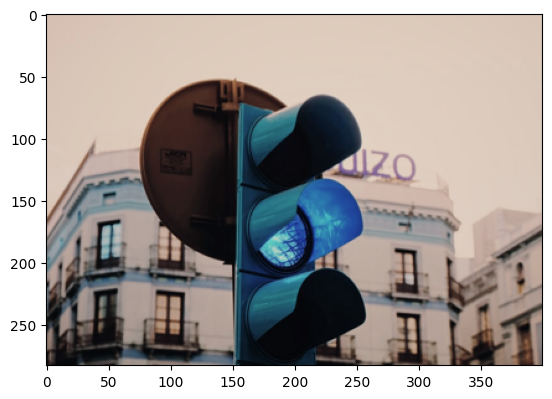

In [13]:
plt.imshow(im)

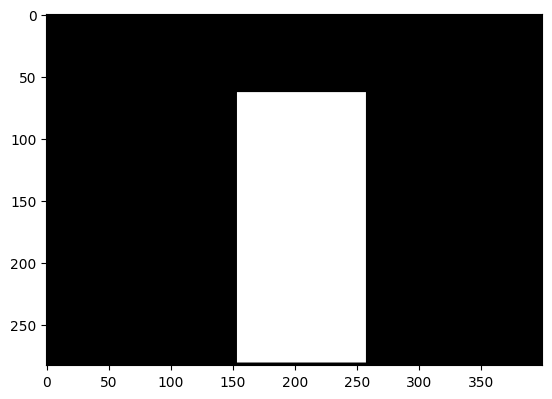

In [14]:
plt.imshow(Y, cmap="gray")

### Data augmentation

Functions in this section borrowed and modified from https://www.usfca.edu/data-institute/certificates/fundamentals-deep-learning

In [15]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c):
    return im[r : r + target_r, c : c + target_c]


# random crop to the original size
def random_crop(x, r_pix=8):
    """Returns a random crop"""
    r, c, *_ = x.shape
    c_pix = round(r_pix * c / r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    return crop(x, start_r, start_c, r - 2 * r_pix, c - 2 * c_pix)


def center_crop(x, r_pix=8):
    r, c, *_ = x.shape
    c_pix = round(r_pix * c / r)
    return crop(x, r_pix, c_pix, r - 2 * r_pix, c - 2 * c_pix)

In [16]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """Rotates an image by deg degrees"""
    r, c, *_ = im.shape
    M = cv2.getRotationMatrix2D((c / 2, r / 2), deg, 1)
    if y:
        return cv2.warpAffine(im, M, (c, r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(
        im, M, (c, r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS + interpolation
    )


def random_cropXY(x, Y, r_pix=8):
    """Returns a random crop"""
    r, c, *_ = x.shape
    c_pix = round(r_pix * c / r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    xx = crop(x, start_r, start_c, r - 2 * r_pix, c - 2 * c_pix)
    YY = crop(Y, start_r, start_c, r - 2 * r_pix, c - 2 * c_pix)
    return xx, YY


def transformsXY(
    path: str, bb: "list[int,int,int,int]", transforms: bool
) -> "tuple[np.array,list[int, int, int, int]]":
    x = cv2.imread(str(path))  # This should be moved out of this function
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random() - 0.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5:
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [17]:
def create_corner_rect(bb, color="red"):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle(
        (bb[1], bb[0]), bb[3] - bb[1], bb[2] - bb[0], color=color, fill=False, lw=3
    )


def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

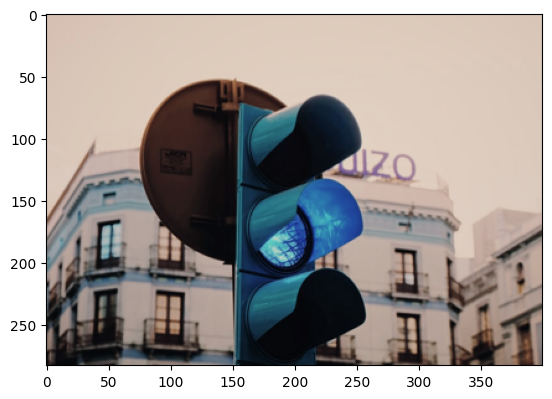

In [18]:
plt.imshow(im)

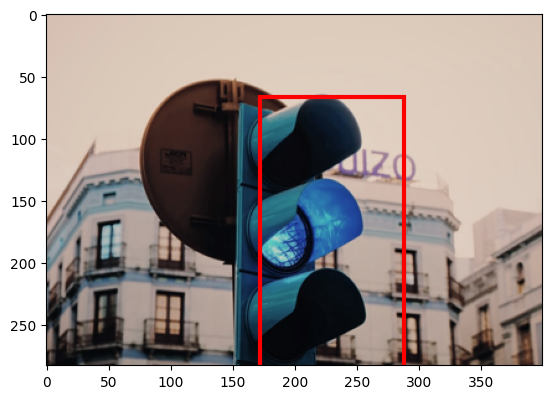

In [19]:
show_corner_bb(im, df_train.values[1][9])

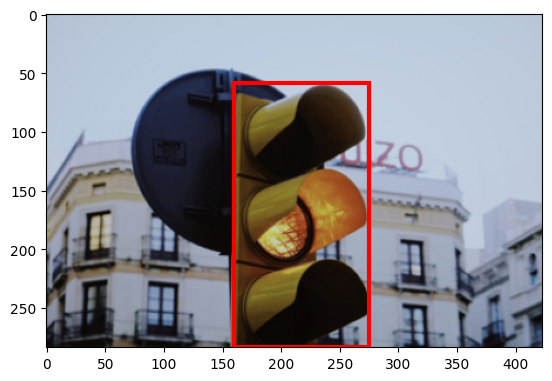

In [20]:
# after transformation
im, bb = transformsXY(str(df_train.values[1][8]), df_train.values[1][9], False)
show_corner_bb(im, bb)

In [21]:
# # Store the image array in the dataframe
# df_train["image"] = df_train["new_path"].apply(lambda x: cv2.imread(x))

### Train validation split

In [22]:
X = df_train[["new_path", "new_bb"]]
Y = df_train["class"]
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]

In [24]:
class TrafficDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [25]:
train_ds = TrafficDataset(
    X_train["new_path"], X_train["new_bb"], y_train, transforms=True
)
valid_ds = TrafficDataset(X_val["new_path"], X_val["new_bb"], y_val)

In [26]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(valid_ds, batch_size=batch_size)

In [27]:
examples = enumerate(train_loader)
batch_idx, (example_x, example_target, example_target_bb) = next(examples)
len(example_x)

32

In [28]:
# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
# Control the threads of CPU to 1 to reduce usage of CPU due to multithreading
"""https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228"""
torch.set_num_threads(1)

In [29]:
class OD_NeuralNetwork(nn.Module):
    def __init__(self):
        super(OD_NeuralNetwork, self).__init__()
        resnet = models.resnet34(weights="ResNet34_Weights.DEFAULT")
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [30]:
# Hyperparameters
epochs = 30
learning_rate = 0.001
momentum = 0.5
log_interval = 10

network = OD_NeuralNetwork()
network = network.to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [31]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [32]:
train_losses_class = []
train_losses_bb = []
train_losses = []
train_counter = []
test_losses_class = []
test_losses_bb = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(epochs + 1)]

In [33]:
def train(epoch):
    network.train()
    for batch_idx, (data, target_class, target_bb) in enumerate(train_loader):
        sum_loss = 0
        # print("len loader", len(train_loader))
        data = data.to(device).float()
        target_class = target_class.to(device)
        target_bb = target_bb.to(device).float()
        output_class, output_bb = network(data)
        optimizer.zero_grad()
        loss_class = F.cross_entropy(output_class, target_class, reduction="sum")
        loss_bb = F.l1_loss(output_bb, target_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        # loss_bb = sum(
        #     loss_bb
        # )  # sum of all the absolute differences between the true value and the predicted coordinates
        loss = (
            loss_class + loss_bb / 1000
        )  # the 1000 is to scale the losses to have them in similar range
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
        train_loss = sum_loss / len(data)
        if batch_idx % log_interval == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.0 * batch_idx / len(train_loader):.2f}%)]\tLoss: {train_loss:.5f}",
            )
            train_losses.append(train_loss)
            train_counter.append(
                (batch_idx * batch_size) + ((epoch - 1) * len(train_loader.dataset))
            )
            torch.save(network.state_dict(), "./results/model.pth")
            torch.save(optimizer.state_dict(), "./results/optimizer.pth")

In [34]:
def test(epoch):
    network.eval()
    correct = 0
    sum_test_loss = 0
    with torch.no_grad():
        for data, target_class, target_bb in test_loader:
            data = data.to(device).float()
            target_class = target_class.to(device)
            target_bb = target_bb.to(device).float()
            output_class, output_bb = network(data)
            test_loss_class = F.cross_entropy(
                output_class, target_class, reduction="sum"
            )
            # test_loss_bb = F.l1_loss(output_bb, target_bb, reduction="none").sum(1)
            test_loss_bb = F.l1_loss(output_bb, target_bb, reduction="none").sum(1)
            test_loss_bb = test_loss_bb.sum()
            test_loss = (
                test_loss_class + test_loss_bb / 1000
            )  # to scale the loss into same range
            # _, pred = torch.max(output_class, 1)
            # print("max_secon_out", pred.eq(target_class).sum().item())
            pred = output_class.data.max(1, keepdim=True)[1]
            # print("max out:", pred.eq(target_class.data.view_as(pred)).sum().item())
            correct += pred.eq(target_class.data.view_as(pred)).sum()
            sum_test_loss += test_loss.item()

    test_loss = sum_test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    print(
        f"\nTest set epoch{epoch}: Avg. loss {test_loss:.5f}, Accuracy: {correct}/{len(test_loader.dataset)}({100.0 * correct / len(test_loader.dataset):.2f}%) \n"
    )

In [35]:
test(0)
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)


Test set epoch0: Avg. loss 1.91983, Accuracy: 75/176(42.61%) 

Train Epoch: 1 [0/701 (0.00%)]	Loss: 2.20680
Train Epoch: 1 [320/701 (45.45%)]	Loss: 1.93274
Train Epoch: 1 [640/701 (90.91%)]	Loss: 1.69019

Test set epoch1: Avg. loss 64.75936, Accuracy: 100/176(56.82%) 

Train Epoch: 2 [0/701 (0.00%)]	Loss: 1.24159
Train Epoch: 2 [320/701 (45.45%)]	Loss: 1.11542
Train Epoch: 2 [640/701 (90.91%)]	Loss: 1.47955

Test set epoch2: Avg. loss 8.36532, Accuracy: 72/176(40.91%) 

Train Epoch: 3 [0/701 (0.00%)]	Loss: 1.19893
Train Epoch: 3 [320/701 (45.45%)]	Loss: 1.23244
Train Epoch: 3 [640/701 (90.91%)]	Loss: 1.09153

Test set epoch3: Avg. loss 31.11306, Accuracy: 70/176(39.77%) 

Train Epoch: 4 [0/701 (0.00%)]	Loss: 2.18506
Train Epoch: 4 [320/701 (45.45%)]	Loss: 1.26857
Train Epoch: 4 [640/701 (90.91%)]	Loss: 0.94386

Test set epoch4: Avg. loss 4.27479, Accuracy: 110/176(62.50%) 

Train Epoch: 5 [0/701 (0.00%)]	Loss: 1.26298
Train Epoch: 5 [320/701 (45.45%)]	Loss: 0.96493
Train Epoch: 5 [640

#### Another way of running a pytorch loop

In [36]:
# def train_epochs(model, optimizer, train_dl, val_dl, epochs=10, C=1000):
#     idx = 0
#     for i in range(epochs):
#         model.train()
#         total = 0
#         sum_loss = 0
#         for batch_idx, (x, y_class, y_bb) in enumerate(train_dl):
#             batch = y_class.shape[0]
#             x = x.to(device).float()
#             y_class = y_class.to(device)
#             y_bb = y_bb.to(device).float()
#             out_class, out_bb = model(x)
#             loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
#             loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
#             loss_bb = loss_bb.sum()
#             loss = loss_class + loss_bb / C
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             idx += 1
#             total += batch
#             sum_loss += loss.item()
#         train_loss = sum_loss / total
#         val_loss, val_acc = val_metrics(model, test_loader, C)
#         print(
#             "train_loss %.3f val_loss %.3f val_acc %.3f"
#             % (train_loss, val_loss, val_acc)
#         )
#     return sum_loss / total

In [37]:
# def val_metrics(model, valid_dl, C=1000):
#     model.eval()
#     total = 0
#     sum_loss = 0
#     correct = 0
#     for x, y_class, y_bb in valid_dl:
#         batch = y_class.shape[0]
#         x = x.to(device).float()
#         y_class = y_class.to(device)
#         y_bb = y_bb.to(device).float()
#         out_class, out_bb = model(x)
#         loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
#         loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
#         loss_bb = loss_bb.sum()
#         loss = loss_class + loss_bb / C
#         _, pred = torch.max(out_class, 1)
#         correct += pred.eq(y_class).sum().item()
#         sum_loss += loss.item()
#         total += batch
#     return sum_loss / total, correct / total

In [38]:
# model = OD_NeuralNetwork().to(device)
# parameters = filter(lambda p: p.requires_grad, model.parameters())
# optimizer = torch.optim.Adam(parameters, lr=0.006)

In [39]:
# train_epochs(model, optimizer, train_loader, test_loader, epochs=15)

In [40]:
# update_optimizer(optimizer, 0.001)
# train_epochs(model, optimizer, train_loader, test_loader, epochs=10)

C:\Users\joses\AppData\Local\Temp\ipykernel_23184\455299218.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


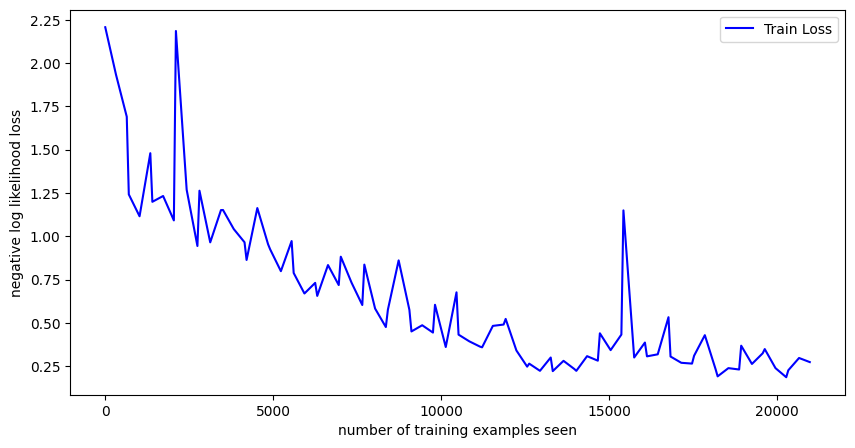

In [41]:
fig = plt.figure(figsize=(10, 5))
plt.plot(train_counter, train_losses, color="blue")
# plt.scatter(test_counter, test_losses, color="red")
plt.legend(["Train Loss", "Test Loss"], loc="upper right")
plt.xlabel("number of training examples seen")
plt.ylabel("negative log likelihood loss")
fig.show()

In [42]:
# resizing test image
im = read_image("../data//traffic_signs/images_resized/road10.png")
im = cv2.resize(im, (int(1.49 * 300), 300))
cv2.imwrite(
    "../data/traffic_signs/road_signs_test/road10.jpg",
    cv2.cvtColor(im, cv2.COLOR_RGB2BGR),
)

True

In [43]:
# test Dataset
test_ds = TrafficDataset(
    pd.DataFrame([{"path": "../data/traffic_signs/road_signs_test/road10.jpg"}])[
        "path"
    ],
    pd.DataFrame([{"bb": np.array([0, 0, 0, 0])}])["bb"],
    pd.DataFrame([{"y": [0]}])["y"],
)
x, y_class, y_bb = test_ds[0]

In [44]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [45]:
# prediction Jose
out_class, out_bb = network(xx.to(device))
out_class, out_bb

(tensor([[-2.3043, -2.1584,  1.4310,  3.5929]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[ 94.1940, 173.5014, 174.1180, 249.6653]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [46]:
# prediction not Jose
# out_class_2, out_bb_2 = model(xx.to(device))
# out_class_2, out_bb_2

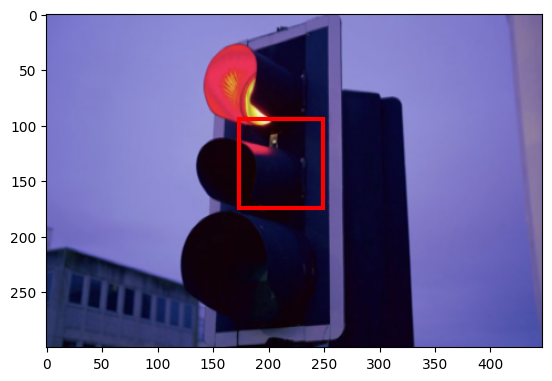

In [47]:
# predicted bounding box Jose
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])

In [48]:
# predicted bounding box not Jose
# bb_hat_2 = out_bb_2.detach().cpu().numpy()
# bb_hat_2 = bb_hat_2.astype(int)
# show_corner_bb(im, bb_hat_2[0])